In [1]:
import pymc3 as pm

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:04:00.0)


In [2]:
import theano.tensor as tt

In [3]:
from fundl.datasets import make_graph_counting_dataset
from fundl.utils import pad_graph
import numpy as onp
import networkx as nx
import jax.numpy as np
from chemgraph import atom_graph
import janitor.chemistry


In [4]:
import pandas as pd

df = (
    pd.read_csv("bace.csv")
    .rename_column("mol", "structure")
    .smiles2mol("structure", "mol")
    .join_apply(lambda x: atom_graph(x["mol"]), "graph")
    .join_apply(lambda x: len(x["graph"]), "graph_size")
)

Gs = df["graph"].tolist()

print("Generating feature matrices and adjacency matrices...")
Fs = []
As = []
for G in Gs:
    Fs.append(onp.vstack([d["features"] for n, d in G.nodes(data=True)])) #WG: What are the features? Are they one-hot encoded?
    As.append(onp.asarray(nx.adjacency_matrix(G).todense())) 

largest_graph_size = max([len(G) for G in Gs])

print("Preparing outputs...")
# Next line is a dummy task, count number of nodes in graph.
# y = np.array([len(G) for G in Gs]).reshape(-1, 1)

# Next line is a real task.
y = df["pIC50"].values.reshape(-1, 1)

print("Padding graphs to correct size...")
for i, (F, A) in enumerate(zip(Fs, As)):
    F, A = pad_graph(F, A, largest_graph_size)
    Fs[i] = F
    As[i] = A


Generating feature matrices and adjacency matrices...
Preparing outputs...
Padding graphs to correct size...


In [5]:
y.min(), y.max()

(2.5445461, 10.522879)

In [6]:
Fs = onp.stack(Fs).astype(float)
As = onp.stack(As).astype(float)

print(Fs.shape)
print(As.shape)


(1513, 97, 9)
(1513, 97, 97)


In [7]:
from fundl.activations import relu, tanh

def dense_params(prefix, input_dim, output_dim):
    w = pm.Normal(f"{prefix}_w", mu=0, sigma=0.1, shape=(input_dim, output_dim))
    b = pm.Normal(f"{prefix}_b", mu=0, sigma=0.1, shape=(output_dim,))
    return dict(w=w, b=b)

def mpnn(params, A, F, nonlin=relu):
    """Follow semantics of fundl.layers.graph.mpnn"""
    F = tt.batched_dot(A, F)
    F = tt.dot(F, params["w"]) + params["b"]
    return nonlin(F)


def gather(F):
    """Follow semantics of fundl.layers.graph.gather"""
    return tt.sum(F, axis=1)

def dense(params, x, nonlin=relu):
    """Follow semantics of fundl.layers.dense"""
    a = nonlin(tt.dot(x, params["w"]) + params["b"])
    return a

In [8]:
def construct_graph_nn_model(As, Fs, y):

    with pm.Model() as model:
        
        As = pm.Data("As", As)
        Fs = pm.Data("Fs", Fs)
        y = pm.Data("y", y)

        # Priors on parameters.
        params = dict()
        params["graph1"] = dense_params("graph1", 9, 9)
        params["graph2"] = dense_params("graph2", 9, 7)
        params["dense1"] = dense_params("dense1", 7, 7)
        params["dense2"] = dense_params("dense2", 7, 1)

        acts1 = mpnn(params["graph1"], As, Fs)
        acts2 = mpnn(params["graph2"], As, acts1, nonlin=tt.tanh)
        out = gather(acts2)
        out = dense(params["dense1"], out)
        out = dense(params["dense2"], out)

        # Prior on noise in measurement.
        sd = pm.Exponential("sd", lam=1)

        # Likelihood
        like = pm.Normal("like", mu=out, sd=sd, observed=y, total_size=1513)
        
    return model

In [15]:
model = construct_graph_nn_model(As, Fs, y)
with model:
    approx = pm.fit(n=50000)
    trace = approx.sample(2000)

Average Loss = 4,078: 100%|██████████| 50000/50000 [03:47<00:00, 219.63it/s]    
Finished [100%]: Average Loss = 4,077.8


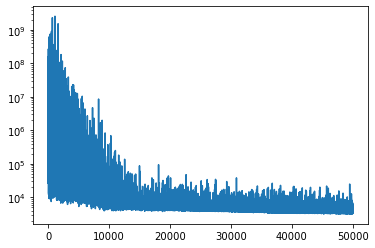

In [16]:
import matplotlib.pyplot as plt
plt.plot(approx.hist)
plt.yscale("log")

(array([  2.,  10.,  69., 227., 480., 513., 407., 213.,  66.,  13.]),
 array([-0.09248044, -0.05135981, -0.01023918,  0.03088146,  0.07200209,
         0.11312272,  0.15424335,  0.19536398,  0.23648462,  0.27760527,
         0.31872588], dtype=float32),
 <a list of 10 Patch objects>)

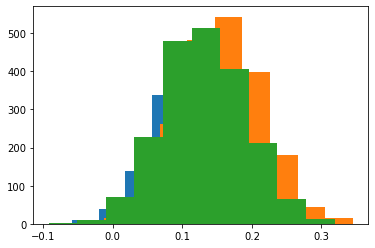

In [76]:
plt.hist(trace["dense2_w"][:, 0, :])
plt.hist(trace["dense2_w"][:, 1, :])
plt.hist(trace["dense2_w"][:, 2, :])#.shape#.mean(axis=0)

In [18]:
with model:
    # pm.set_data(new_data={'As': As, 'Fs': Fs, 'Y': y})
    # ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)
    samples = pm.sample_posterior_predictive(trace, samples=500)

100%|██████████| 500/500 [00:10<00:00, 47.52it/s]


In [77]:
samples["like"].shape

(500, 1513, 1)

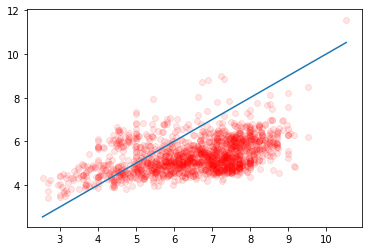

In [19]:
plt.scatter(y, samples["like"].mean(axis=0), color='red', alpha=0.1)

plt.plot([y.min(), y.max()], [y.min(), y.max()])

Not bad for training a teensy weensy neural network!

What is the variance explained?

In [30]:
score = 1 - np.var(y - samples["like"].mean(axis=0))/np.var(y)
score

DeviceArray(0.17059827, dtype=float32)

Let's see what the uncertainty looks like.

/home/maer3/anaconda/envs/fundl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  if sys.path[0] == '':


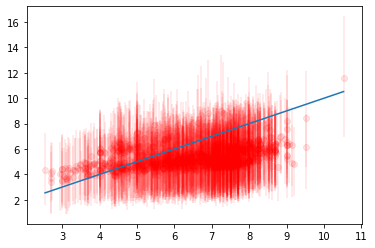

In [20]:
l, m, u = np.percentile(samples["like"], q=[25, 50, 75], axis=0)

ldiff = m - l
udiff = u - m

plt.errorbar(
    y, 
    samples["like"].mean(axis=0),
    yerr=[ldiff, udiff],
    fmt='none',
    color="red",
    alpha=0.1
)
plt.scatter(y, samples["like"].mean(axis=0), color='red', alpha=0.1)
plt.plot([y.min(), y.max()], [y.min(), y.max()])

One thing to note here is that the error model we have presumed is **homoskedastic**, i.e. equal variance on each sample. What would have been more principled would be to assume **heteroskedasticity**, i.e. non-equal variance per sample, and explicitly write a model to predict that variance.

# Compare with vanilla GNN

In [54]:
from fundl.layers.graph import mpnn as mpnn_, gather as gather_
from fundl.layers import dense as dense_
from fundl.weights import add_dense_params
from fundl.losses import _mse_loss

import jax.numpy as np
from jax import grad


In [58]:
def model(param, A, F):
    acts1 = mpnn_(params["graph1"], As, Fs, nonlin=relu)
    acts2 = mpnn_(params["graph2"], As, acts1, nonlin=tanh)
    out = gather_(acts2)
    out = dense_(params["dense1"], out, nonlin=relu)
    out = dense_(params["dense2"], out, nonlin=relu)
    return out

In [63]:
# Priors on parameters.
params = dict()
params = add_dense_params(params, "graph1", 9, 9)
params = add_dense_params(params, "graph2", 9, 7)
params = add_dense_params(params, "dense1", 7, 7)
params = add_dense_params(params, "dense2", 7, 1)

In [60]:
def mseloss(p, model, Fs, As, y):
    yhat = model(p, Fs, As)
    return np.mean(_mse_loss(y, yhat))

In [68]:
model(params, Fs, As)

DeviceArray([[0.00137879],
             [0.00141805],
             [0.00139337],
             ...,
             [0.00136475],
             [0.00136152],
             [0.00136327]], dtype=float32)

In [65]:
dloss = grad(mseloss)

from jax.experimental.optimizers import adam

init, update, get_params = adam(step_size=0.01)

state = init(params)
for i in range(1000):
    g = dloss(params, model, Fs, As, y)
    print(g)
    l = mseloss(params, model, Fs, As, y)

    state = update(i, g, state)
    params = get_params(state)
    preds = model(params, Fs, As)

    print(i, l)


{'dense1': {'b': _FilledConstant([0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'w': _FilledConstant([[0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, 'dense2': {'b': _FilledConstant([0.], dtype=float32), 'w': _FilledConstant([[0.],
                 [0.],
                 [0.],
                 [0.],
                 [0.],
                 [0.],
                 [0.]], dtype=float32)}, 'graph1': {'b': _FilledConstant([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'w': _FilledConstant([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0., 0., 0.],
                 [0., 0., 0., 0., 0., 0., 0., 0., 0.],
                 [0.

KeyboardInterrupt: 